# **AssignmentGPT with LangChain - By Afaq Khan**






0.   Installs, Imports and API Keys
1.   Loading PDFs and chunking with LangChain
2.   Embedding text and storing embeddings
3.   Creating retrieval function
4.   Creating chatbot with chat memory (OPTIONAL)








# 0. Installs, Imports and API Keys

In [ ]:
# Used 0.28.1 of openai and 0.0.330 because of a minor issue
# issue was that in the later versions of openai, they changed a variable name and langchain only had the old history of openai
!pip install openai==0.28.1
!pip install langchain==0.0.330
!pip install pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

In [ ]:
!pip install -U six

In [ ]:
!pip install -U typing-extensions

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

In [15]:
from google.colab import userdata
key = userdata.get('api_key')
os.environ["OPENAI_API_KEY"] = key

In [6]:
# Splitting by chunks

# Step 1: Convert PDF to text
import textract
doc = textract.process("/content/ai-lab-manual.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('attention_is_all_you_need.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('attention_is_all_you_need.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [7]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0])

langchain.schema.document.Document

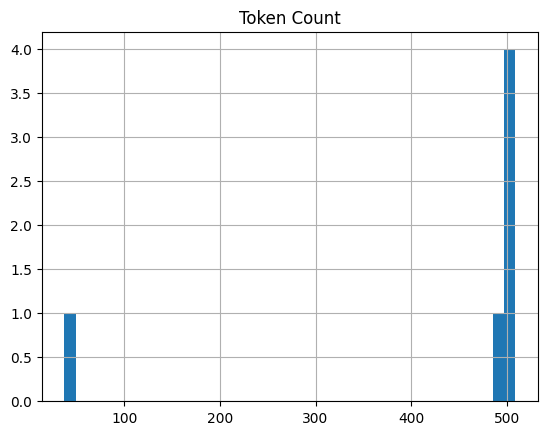

In [8]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

# 2. Embed text and store embeddings

In [9]:

# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

# 3. Setup retrieval function

In [10]:
# Check similarity search is working, this will give 4 different relevant answers (context) which will be fed to OpenAI/LLAMA2 later in the code
query = "Can you give me the solution for Task 1?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='1.5. Evaluation Tasks\n\n(Marks 10)\n1.5.1.Task 1\nWrite a python program to print the multiplication table for a number and range given\nby a user?\nFor example: the number is 2 and the range is 11 to 13 and the output will be:\n\n2\n2\n2\n\nx\nx\nx\n\n11\n12\n13\n\n=\n=\n=\n\n22\n24\n26\n\n1.5.2.Task 2\n(Marks 10)\nWrite a python program using function to check whether the positive integer is prime\nor not. The number will be given by the user that lies between 0 to 1000. For example,\nfor input 5 the output will be displayed as “prime number”. For input 6, the output will\nbe “not a prime number”.\n\n1.5.3.Task 3\n\n(Marks 10)\n\n\x0cWrite a Python program that accepts a positive integer (n) and computes the sum of\nsquares from 1 to n. For example: n is 3 so the sum will be 14 and for n is 5 the sum\nwill be 55.\n\n1.6. Evaluation using Rubrics\n\nThe evaluation criteria for this lab will be based on the completion of the following\ntasks. Each task is assign

In [11]:
# create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff") # initializing a chain using OpenAI

query = "Can you give me the solution for Task 1?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

'\n\nThe solution for Task 1 is:\n\nnumber = int(input("Enter a number: "))\nstart = int(input("Enter the start of the range: "))\nend = int(input("Enter the end of the range: "))\n\nfor i in range(start, end+1):\n    print(number, "x", i, "=", number*i)'

# 5. Create chatbot with chat memory (OPTIONAL)

In [12]:
from IPython.display import display
import ipywidgets as widgets

# create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [16]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you for using the AssignmentBot!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the AssignmentBot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the AssignmentBot! Type 'exit' to stop.


Text(value='', placeholder='Please enter your question:')

HTML(value='<b>User:</b> How are')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Semicolons are used to separate statements in Python. T…

HTML(value='<b>User:</b> How are you?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  I don\'t know.')

HTML(value='<b>User:</b> What is this Lab about?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  The purpose of this lab is to introduce students to the…